In [17]:
## Import Libraries
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import openpyxl

pd.set_option("max_colwidth", None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [18]:
'''
function name: parse_df_columns

purpose: parsing the last aggregate column of the gtf/gff3 into useful columns and cleaning non-relevant columns

input: dataframe containining "raw" gtf/gff

output: dataframe containing gtf with useful columns ["gene_id", "transcript_id", etc...]
'''

def parse_df_columns(df, is_ref=True):

    if is_ref:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split("source_gene=", expand=True)[1].str.split(';', expand=True)[0]
        
        ## Get gene names
        df["gene_name"] = df["other"].str.split("source_gene_common_name=", expand=True)[1].str.split(';', expand=True)[0]
        
        ## Only keep relevant
        df = df[["chr", "gene_id", "gene_name"]].copy()

        ## Drop duplicates
        df.drop_duplicates(inplace=True)
        

    else:

        ## Get CHM gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)

        ## Drop "other" column
        df = df[["chr", "gene_id"]].copy()
        
    for col in df.columns:
        df.loc[df[col].isnull(), col] = np.NaN
        

    return df

In [19]:
'''
function name: calculate_cpm

purpose: Calculate CPM for the each sample given

input: Counts dataset

output: Counts dataset with CPM columns as well
'''

def calculate_cpm(df):

    ## Loop through counts columns to calculate CPM and add to the dataframe
    for col in ["total_counts"]:
        
        df[col] = round(df[col], 2)
        cpm_name = col.replace("_counts", "_CPM")
        df[cpm_name] = round(((df[col]/(df[col].sum())) * 1000000), 2)
    
    return df 

In [20]:
## Import transcripts
df_transcripts = pd.read_csv(("C:/Users/local_bag222/OneDrive - University of Kentucky/programming/ebbert_lab/data/"
                             "aged_cDNA_data/GRCh38-106_good_ONT/bambu_discovery/counts_transcript.txt"), sep="\t",
                names=["TXNAME", "GENEID", "sample_PAM54788", "sample_PAM54335", "sample_PAM54401", "sample_PAM54902"],
                             low_memory=False, header=0)

In [21]:
## Import Genes
df_genes = pd.read_csv(("C:/Users/local_bag222/OneDrive - University of Kentucky/programming/ebbert_lab/data/"
                             "aged_cDNA_data/GRCh38-106_good_ONT/bambu_discovery/counts_gene.txt"), sep="\t", 
                       names=["GENEID", "sample_PAM54788", "sample_PAM54335", "sample_PAM54401", "sample_PAM54902"],
                       low_memory=False, header=0)

In [22]:
## Get total counts for genes and transcripts
df_genes["total_counts"] = df_genes[["sample_PAM54788", "sample_PAM54335", "sample_PAM54401", "sample_PAM54902"]].sum(axis=1)
df_transcripts["total_counts"] = df_transcripts[["sample_PAM54788", "sample_PAM54335", "sample_PAM54401", "sample_PAM54902"]].sum(axis=1)

In [23]:
## Only keep genes and transcripts with more than 0 counts
df_genes = df_genes.loc[df_genes["total_counts"] > 0].copy()
df_transcripts = df_transcripts.loc[df_transcripts["total_counts"] > 0].copy()

In [24]:
## Calculate percentile
df_genes['percentile'] = df_genes["total_counts"].rank(pct=True)

In [25]:
## Calculate Rank
df_genes['rank'] = df_genes["total_counts"].rank(ascending=False)

In [26]:
## See rank for COL4A1
df_genes.loc[df_genes["GENEID"].str.contains("ENSG00000187498")]

,GENEID,sample_PAM54788,sample_PAM54335,sample_PAM54401,sample_PAM54902,total_counts,percentile,rank
16439,ENSG00000187498,238,185,227,242,892,0.785503,10956.0


In [27]:
## See rank for PIK3R5
df_genes.loc[df_genes["GENEID"].str.contains("ENSG00000266389")]

,GENEID,sample_PAM54788,sample_PAM54335,sample_PAM54401,sample_PAM54902,total_counts,percentile,rank
48588,ENSG00000266389,2,4,0,0,6,0.180281,41866.5


In [28]:
## Calculate log10 total counts
df_genes["log10_total_counts"] = np.log10(df_genes["total_counts"])

In [29]:
## Get total counts for all genes with more than 0 counts
total_counts = df_genes["total_counts"]

In [30]:
## Get log total counts
log_total_counts = df_genes["log10_total_counts"]

In [31]:
## Use ggplot colors
ggplot2_colors = ["#F8766D", "#CD9600", "#7CAE00", "#00BE67", "#00BFC4", "#00A9FF", "#C77CFF", "#FF61CC"]

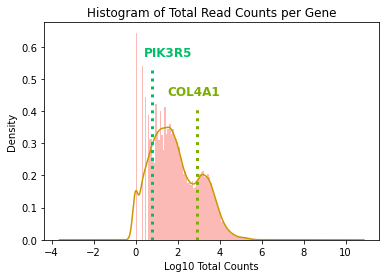

In [32]:
## Create log plot

fig, ax = plt.subplots(figsize = (6,4))


log_total_counts.plot(kind = "hist", density = True, bins = 100, color="#F8766D", alpha=0.5) # change density to true, because KDE uses density


log_total_counts.plot(kind = "kde", color="#CD9600", alpha=1)

ax.set_xlabel("Log10 Total Counts")


ax.set_title("Histogram of Total Read Counts per Gene")

ax.axvline(2.950365, alpha=1, ymax = 0.60, linestyle = ":", color="#7CAE00", lw=3)
ax.axvline(0.778151, alpha=1, ymax = 0.80, linestyle = ":", color="#00BE67", lw=3)


ax.text(1.5, 0.45, "COL4A1", size = 12, alpha = 1, color="#7CAE00", weight='bold')
ax.text(0.4, 0.57, "PIK3R5", size = 12, alpha = 1, color="#00BE67", weight='bold')


plt.show()

In [35]:
## Import extended annotation
gtf = pd.read_csv(("C:/Users/local_bag222/OneDrive - University of Kentucky/programming/ebbert_lab/data/"
                             "aged_cDNA_data/GRCh38-106_good_ONT/bambu_discovery/extended_annotations.gtf"),
        sep="\t", names=["chr", "source", "type", "start", 
                               "end", "dot_1", "strand", "dot_2", "other"], low_memory=False, header=0)

In [36]:
## Parse through it
gtf = parse_df_columns(gtf, is_ref=False)

In [37]:
## Get gene ids for mitochondrial genes
gtf_mito_ids = gtf.loc[gtf["chr"] == "MT"]["gene_id"]

In [38]:
## Select only nuclear genes
df_genes_nuclear = df_genes.loc[~df_genes["GENEID"].isin(gtf_mito_ids)]

In [39]:
## Total counts for nuclear genes
total_counts_nuclear = df_genes_nuclear["total_counts"]

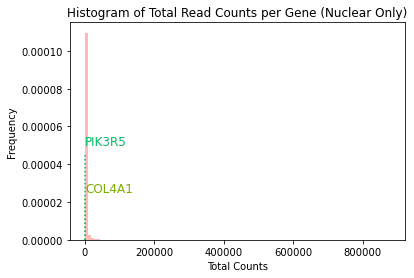

In [40]:
## Make graph for nuclear genes
fig, ax = plt.subplots(figsize = (6,4))

total_counts_nuclear.plot(kind = "hist", density = True, bins = 100, color="#F8766D", alpha=0.5) # change density to true, because KDE uses density

ax.set_xlabel("Total Counts")

ax.set_title("Histogram of Total Read Counts per Gene (Nuclear Only)")

ax.axvline(892, alpha=1, ymax = 0.2, linestyle = ":", color="#7CAE00")
ax.axvline(6, alpha=1, ymax = 0.4, linestyle = ":", color="#00BE67")

ax.text(892, 0.000025, "COL4A1", fontsize = 12, alpha = 1, color="#7CAE00")
ax.text(6, 0.000050, "PIK3R5", fontsize = 12, alpha = 1, color="#00BE67")

plt.show()

#####################################################################################################

In [41]:
## Look at COL4A1 Expression
df_transcripts.loc[df_transcripts["GENEID"].str.contains("ENSG00000187498")]

,TXNAME,GENEID,sample_PAM54788,sample_PAM54335,sample_PAM54401,sample_PAM54902,total_counts
25818,ENST00000375820,ENSG00000187498,1.698380e+02,9.545242e+01,127.454516,1.003447e+02,4.930896e+02
75034,ENST00000467182,ENSG00000187498,0.000000e+00,8.000000e-16,0.000000,0.000000e+00,8.000000e-16
80832,ENST00000474391,ENSG00000187498,0.000000e+00,8.000000e-16,0.000000,1.000000e+00,1.000000e+00
134719,ENST00000543140,ENSG00000187498,0.000000e+00,5.657246e-10,2.123344,5.992019e+00,8.115363e+00
184081,ENST00000615732,ENSG00000187498,0.000000e+00,2.746369e+01,46.538724,6.783859e+01,1.418410e+02
201548,ENST00000647632,ENSG00000187498,0.000000e+00,3.393400e-12,7.122427,9.255000e-13,7.122427e+00
201703,ENST00000647797,ENSG00000187498,3.000000e-16,3.800572e+00,24.419750,3.825383e-09,2.822032e+01
202052,ENST00000648170,ENSG00000187498,0.000000e+00,0.000000e+00,0.000000,2.000000e+00,2.000000e+00
203505,ENST00000649720,ENSG00000187498,6.716197e+01,5.828332e+01,16.341237,6.482473e+01,2.066113e+02
203521,ENST00000649738,ENSG00000187498,1.496288e-06,1.436179e-06,0.000001,8.937830e-07,5.076239e-06


In [42]:
## Look at PIK3R5 Expression
df_transcripts.loc[df_transcripts["GENEID"].str.contains("ENSG00000266389")]

,TXNAME,GENEID,sample_PAM54788,sample_PAM54335,sample_PAM54401,sample_PAM54902,total_counts
165021,ENST00000585297,ENSG00000266389,2.0,4.0,0.0,0.0,6.0
